In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


# 1. Data Preparation

In [ ]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from pprint import pprint
import regex
import spacy
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import random
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Activation, Input, Dense, Dropout, BatchNormalization, \
LSTM, GRU, Bidirectional, Flatten, concatenate, Embedding, Reshape, GlobalAveragePooling1D, \
Attention, BatchNormalization
from keras.callbacks import EarlyStopping
from keras import optimizers, regularizers
from sklearn.metrics import plot_roc_curve, roc_curve, \
auc, precision_score, recall_score, confusion_matrix, \
classification_report, accuracy_score, f1_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta

nltk.download('universal_tagset')
nltk.download('punkt')
random.seed(1)

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/stock_prediction/data/All_News.csv')
df.drop(columns=[df.columns[0],df.columns[5]], axis=1, inplace=True)
df.shape

(5681, 5)

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/stock_prediction/data/All_News_update.csv')
df1.drop(columns=[df1.columns[0],df1.columns[5]], axis=1, inplace=True)
df1.shape

(18, 5)

In [ ]:
df = df.append(df1)
df.shape

(5699, 5)

## Filter Company

In [ ]:
df = df[df['company_name'] == 'Apple']
df.shape

(1838, 5)

## Remove Duplicates

In [ ]:
#remove duplicates
nb_rows = df.shape[0]
df.drop_duplicates(inplace=True)
print('# duplicates: ', nb_rows - df.shape[0])

# duplicates:  0


## Missing Value

In [ ]:
#check null
def check_missing_values(row):
    """ functions that check and verifies if there are missing values in dataframe """
    counter = 0
    for element in row:
        if element == True:
            counter+=1
    return ("# Empty entries:", counter)

df.isnull().apply(lambda x: check_missing_values(x)).transpose()

,0,1
Date,# Empty entries:,0
Title,# Empty entries:,0
Url,# Empty entries:,0
Body,# Empty entries:,28
company_name,# Empty entries:,0


## Adjust Published Date

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d').dt.date
df.head()

,Date,Title,Url,Body,company_name
0,2021-05-21,Epic v Apple: Tim Cook testifies as star witne...,https://www.theguardian.com/technology/2021/ma...,"<p>Tim Cook, the chief executive of Apple, too...",Apple
1,2021-05-19,Apple iPad Pro M1 review: stunning screen and ...,https://www.theguardian.com/technology/2021/ma...,<p>Apple’s latest iPad Pro gets upgraded with ...,Apple
2,2021-05-18,"Apple 24in iMac M1 review: faster, bigger scr...",https://www.theguardian.com/technology/2021/ma...,<p>Apple’s iMac has had its first big redesign...,Apple
3,2021-05-02,Why are Apple and Epic going to court over For...,https://www.theguardian.com/technology/2021/ma...,<p>Apple and Epic Games will go head to head i...,Apple
4,2021-04-30,Apple accused of breaking EU law over App Stor...,https://www.theguardian.com/technology/2021/ap...,<p>Apple has been accused of breaking EU law b...,Apple


In [ ]:
df['wday'] = pd.to_datetime(df['Date'], format='%Y-%m-%d').dt.dayofweek
df

,Date,Title,Url,Body,company_name,wday
0,2021-05-21,Epic v Apple: Tim Cook testifies as star witne...,https://www.theguardian.com/technology/2021/ma...,"<p>Tim Cook, the chief executive of Apple, too...",Apple,4
1,2021-05-19,Apple iPad Pro M1 review: stunning screen and ...,https://www.theguardian.com/technology/2021/ma...,<p>Apple’s latest iPad Pro gets upgraded with ...,Apple,2
2,2021-05-18,"Apple 24in iMac M1 review: faster, bigger scr...",https://www.theguardian.com/technology/2021/ma...,<p>Apple’s iMac has had its first big redesign...,Apple,1
3,2021-05-02,Why are Apple and Epic going to court over For...,https://www.theguardian.com/technology/2021/ma...,<p>Apple and Epic Games will go head to head i...,Apple,6
4,2021-04-30,Apple accused of breaking EU law over App Stor...,https://www.theguardian.com/technology/2021/ap...,<p>Apple has been accused of breaking EU law b...,Apple,4
...,...,...,...,...,...,...
0,2021-06-07,"WWDC 2021: Apple unveils iOS 15, ‘focus mode’ ...",https://www.theguardian.com/technology/live/20...,"<div id=""block-60be828c8f08336d75f05ed3"" class...",Apple,0
1,2021-06-07,Apple overhauls Siri to address privacy concer...,https://www.theguardian.com/technology/2021/ju...,<p>Apple will no longer send Siri requests to ...,Apple,0
2,2021-06-07,Apple paid woman millions after technicians us...,https://www.theguardian.com/technology/2021/ju...,<p>Apple has paid a multi-million dollar settl...,Apple,0
3,2021-06-03,Apple uses more suppliers from China than Taiw...,https://www.theguardian.com/technology/2021/ju...,<p>Apple used more suppliers from China last y...,Apple,3


In [ ]:
df.groupby('wday').count()

,Date,Title,Url,Body,company_name
wday,,,,,
0,342,342,342,341,342
1,373,373,373,365,373
2,361,361,361,352,361
3,324,324,324,321,324
4,344,344,344,337,344
5,39,39,39,39,39
6,55,55,55,55,55


In [ ]:
def adjusted_date(row):
    if row['wday'] < 4 or row['wday'] == 6:
        return row['Date'] + timedelta(days=1)
    elif row['wday'] == 5:
        return row['Date'] + timedelta(days=2)
    else:
        return row['Date'] + timedelta(days=3)

In [ ]:
df['adjusted_date'] = df.apply(lambda row: adjusted_date(row), axis=1)
df

,Date,Title,Url,Body,company_name,wday,adjusted_date
0,2021-05-21,Epic v Apple: Tim Cook testifies as star witne...,https://www.theguardian.com/technology/2021/ma...,"<p>Tim Cook, the chief executive of Apple, too...",Apple,4,2021-05-24
1,2021-05-19,Apple iPad Pro M1 review: stunning screen and ...,https://www.theguardian.com/technology/2021/ma...,<p>Apple’s latest iPad Pro gets upgraded with ...,Apple,2,2021-05-20
2,2021-05-18,"Apple 24in iMac M1 review: faster, bigger scr...",https://www.theguardian.com/technology/2021/ma...,<p>Apple’s iMac has had its first big redesign...,Apple,1,2021-05-19
3,2021-05-02,Why are Apple and Epic going to court over For...,https://www.theguardian.com/technology/2021/ma...,<p>Apple and Epic Games will go head to head i...,Apple,6,2021-05-03
4,2021-04-30,Apple accused of breaking EU law over App Stor...,https://www.theguardian.com/technology/2021/ap...,<p>Apple has been accused of breaking EU law b...,Apple,4,2021-05-03
...,...,...,...,...,...,...,...
0,2021-06-07,"WWDC 2021: Apple unveils iOS 15, ‘focus mode’ ...",https://www.theguardian.com/technology/live/20...,"<div id=""block-60be828c8f08336d75f05ed3"" class...",Apple,0,2021-06-08
1,2021-06-07,Apple overhauls Siri to address privacy concer...,https://www.theguardian.com/technology/2021/ju...,<p>Apple will no longer send Siri requests to ...,Apple,0,2021-06-08
2,2021-06-07,Apple paid woman millions after technicians us...,https://www.theguardian.com/technology/2021/ju...,<p>Apple has paid a multi-million dollar settl...,Apple,0,2021-06-08
3,2021-06-03,Apple uses more suppliers from China than Taiw...,https://www.theguardian.com/technology/2021/ju...,<p>Apple used more suppliers from China last y...,Apple,3,2021-06-04


In [ ]:
df.groupby('adjusted_date').count()[['Title']].sort_values(by=['Title'], ascending=False)

,Title
adjusted_date,
2013-10-23,14
2014-09-10,11
2013-09-11,10
2014-09-11,9
2014-10-17,8
...,...
2013-04-25,1
2015-08-17,1
2015-08-20,1


In [ ]:
df_news = df.groupby('adjusted_date')['Title'].apply(' '.join).reset_index()
df_news

,adjusted_date,Title
0,2012-05-21,"Boot up: web v apps, Google v France, the iPho..."
1,2012-05-24,"Boot up: Facebook's coming crash, iPhone gende..."
2,2012-05-28,Apple chief Tim Cook opts out of $75m dividend...
3,2012-06-04,"Boot up: iPhone v Lumia, shiny Chromebook?, Fl..."
4,2012-06-07,30/30 app brings pay-what-you-like pricing to ...
...,...,...
1094,2021-05-20,Apple iPad Pro M1 review: stunning screen and ...
1095,2021-05-24,Epic v Apple: Tim Cook testifies as star witne...
1096,2021-05-31,"Apple TV 4K 2021 review: faster chip, fancy iP..."
1097,2021-06-04,Apple uses more suppliers from China than Taiw...


In [ ]:
df_news.rename({'adjusted_date': 'Date'}, axis=1, inplace=True)
df_news

,Date,Title
0,2012-05-21,"Boot up: web v apps, Google v France, the iPho..."
1,2012-05-24,"Boot up: Facebook's coming crash, iPhone gende..."
2,2012-05-28,Apple chief Tim Cook opts out of $75m dividend...
3,2012-06-04,"Boot up: iPhone v Lumia, shiny Chromebook?, Fl..."
4,2012-06-07,30/30 app brings pay-what-you-like pricing to ...
...,...,...
1094,2021-05-20,Apple iPad Pro M1 review: stunning screen and ...
1095,2021-05-24,Epic v Apple: Tim Cook testifies as star witne...
1096,2021-05-31,"Apple TV 4K 2021 review: faster chip, fancy iP..."
1097,2021-06-04,Apple uses more suppliers from China than Taiw...


## Text Tokenization

In [ ]:
#decontract to not create token from special cases.
#For example, "won't" or " can't" can generate tokens as "wo", "ca" which are not removed by stopwords

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"let\'s", "let us", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

#convert to lower case and decontract
df_news['text_decont'] = df_news['Title'].str.lower().apply(lambda x: decontracted(x))

#remove punctuation
df_news['text_no_punc'] = df_news['text_decont'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))

df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1099 entries, 0 to 1098
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          1099 non-null   object
 1   Title         1099 non-null   object
 2   text_decont   1099 non-null   object
 3   text_no_punc  1099 non-null   object
dtypes: object(4)
memory usage: 34.5+ KB


In [ ]:
# tokenize w/o preprocessing
df_news['tk'] = df_news['text_no_punc'].apply(lambda x: nltk.word_tokenize(x))
df_news.head()

,Date,Title,text_decont,text_no_punc,tk
0,2012-05-21,"Boot up: web v apps, Google v France, the iPho...","boot up: web v apps, google v france, the ipho...",boot up web v apps google v france the ipho...,"[boot, up, web, v, apps, google, v, france, th..."
1,2012-05-24,"Boot up: Facebook's coming crash, iPhone gende...","boot up: facebook is coming crash, iphone gend...",boot up facebook is coming crash iphone gend...,"[boot, up, facebook, is, coming, crash, iphone..."
2,2012-05-28,Apple chief Tim Cook opts out of $75m dividend...,apple chief tim cook opts out of $75m dividend...,apple chief tim cook opts out of 75m dividend...,"[apple, chief, tim, cook, opts, out, of, 75m, ..."
3,2012-06-04,"Boot up: iPhone v Lumia, shiny Chromebook?, Fl...","boot up: iphone v lumia, shiny chromebook?, fl...",boot up iphone v lumia shiny chromebook fl...,"[boot, up, iphone, v, lumia, shiny, chromebook..."
4,2012-06-07,30/30 app brings pay-what-you-like pricing to ...,30/30 app brings pay-what-you-like pricing to ...,30 30 app brings pay what you like pricing to ...,"[30, 30, app, brings, pay, what, you, like, pr..."


# 2. TF-IDF

In [ ]:
def identity_tokenizer(text):
    return text

tfvec = TfidfVectorizer(lowercase=False, tokenizer=identity_tokenizer)
df_tfvec = tfvec.fit_transform(df_news.tk.tolist()).todense()

In [ ]:
len(tfvec.get_feature_names())

3892

In [ ]:
df_tfvec

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
df_tfidf = pd.DataFrame(df_tfvec)
df_tfidf

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3852,3853,3854,3855,3856,3857,3858,3859,3860,3861,3862,3863,3864,3865,3866,3867,3868,3869,3870,3871,3872,3873,3874,3875,3876,3877,3878,3879,3880,3881,3882,3883,3884,3885,3886,3887,3888,3889,3890,3891
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.262269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1097,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
temp = np.empty(df_tfidf.shape[0], dtype=object)
temp[:] = df_tfidf.values.tolist()

In [ ]:
df_temp = pd.DataFrame(temp, columns=['tfidf'])
df_temp

,tfidf
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...
1094,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1095,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1096,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1097,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
df_news = df_news.join(df_temp)
df_news.head()

,Date,Title,text_decont,text_no_punc,tk,tfidf
0,2012-05-21,"Boot up: web v apps, Google v France, the iPho...","boot up: web v apps, google v france, the ipho...",boot up web v apps google v france the ipho...,"[boot, up, web, v, apps, google, v, france, th...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2012-05-24,"Boot up: Facebook's coming crash, iPhone gende...","boot up: facebook is coming crash, iphone gend...",boot up facebook is coming crash iphone gend...,"[boot, up, facebook, is, coming, crash, iphone...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2012-05-28,Apple chief Tim Cook opts out of $75m dividend...,apple chief tim cook opts out of $75m dividend...,apple chief tim cook opts out of 75m dividend...,"[apple, chief, tim, cook, opts, out, of, 75m, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2012-06-04,"Boot up: iPhone v Lumia, shiny Chromebook?, Fl...","boot up: iphone v lumia, shiny chromebook?, fl...",boot up iphone v lumia shiny chromebook fl...,"[boot, up, iphone, v, lumia, shiny, chromebook...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2012-06-07,30/30 app brings pay-what-you-like pricing to ...,30/30 app brings pay-what-you-like pricing to ...,30 30 app brings pay what you like pricing to ...,"[30, 30, app, brings, pay, what, you, like, pr...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## Load Stock Price Data

In [ ]:
df_stock = pd.read_csv('/content/drive/MyDrive/stock_prediction/data/Stock Price - AAPL.csv', skiprows=1)
df_stock.head()

,Date,Close
0,5/18/2012 16:00:00,18.94
1,5/21/2012 16:00:00,20.05
2,5/22/2012 16:00:00,19.89
3,5/23/2012 16:00:00,20.38
4,5/24/2012 16:00:00,20.19


In [ ]:
df_stock['Date'] = pd.to_datetime(df_stock['Date'], infer_datetime_format=True).dt.date

In [ ]:
df_stock = df_stock.set_index('Date').join(df_news.set_index('Date'))

In [ ]:
df_stock.reset_index(inplace=True)

## Replace NaN TI-IDF by Zero Vector

In [ ]:
def tfidf_zero(list_):
    if type(list_) == float:
        list_ = np.zeros(len(tfvec.get_feature_names()), dtype=float)
    else:
        list_ = np.array(list_)
    return list_

In [ ]:
df_stock['tfidf_new'] = df_stock['tfidf'].apply(lambda x: tfidf_zero(x))

In [ ]:
df_stock.reset_index(inplace=True)

In [ ]:
df_stock

,index,Date,Close,Title,text_decont,text_no_punc,tk,tfidf,tfidf_new
0,0,2012-05-18,18.94,NaN,NaN,NaN,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,2012-05-21,20.05,"Boot up: web v apps, Google v France, the iPho...","boot up: web v apps, google v france, the ipho...",boot up web v apps google v france the ipho...,"[boot, up, web, v, apps, google, v, france, th...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,2012-05-22,19.89,NaN,NaN,NaN,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,2012-05-23,20.38,NaN,NaN,NaN,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,2012-05-24,20.19,"Boot up: Facebook's coming crash, iPhone gende...","boot up: facebook is coming crash, iphone gend...",boot up facebook is coming crash iphone gend...,"[boot, up, facebook, is, coming, crash, iphone...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...
2275,2275,2021-06-04,125.89,Apple uses more suppliers from China than Taiw...,apple uses more suppliers from china than taiw...,apple uses more suppliers from china than taiw...,"[apple, uses, more, suppliers, from, china, th...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2276,2276,2021-06-07,125.90,NaN,NaN,NaN,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2277,2277,2021-06-08,126.74,"WWDC 2021: Apple unveils iOS 15, ‘focus mode’ ...","wwdc 2021: apple unveils ios 15, ‘focus mode’ ...",wwdc 2021 apple unveils ios 15 focus mode ...,"[wwdc, 2021, apple, unveils, ios, 15, focus, m...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2278,2278,2021-06-09,127.13,NaN,NaN,NaN,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# 3. Train-test split

In [ ]:
df_stock = df_stock.fillna('')

In [ ]:
df_stock['Date'] = pd.to_datetime(df_stock['Date'], format='%Y-%m-%d')

train_data = df_stock[df_stock['Date'] < '2020-01-01'].copy()
val_data = df_stock[df_stock['Date'] < '2020-09-01'][df_stock['Date'] > '2019-12-31'].copy()
test_data = df_stock[df_stock['Date'] > '2020-08-31'].copy()

val_data = val_data.set_index('Date')
train_data = train_data.set_index('Date')
test_data = test_data.set_index('Date')

print('Training set:', train_data.shape[0], 'accounted for ',train_data.shape[0]/df_stock.shape[0]*100,'%')
print('Val set:', val_data.shape[0], 'accounted for ',val_data.shape[0]/df_stock.shape[0]*100,'%')
print('Test set:', test_data.shape[0], 'accounted for ',test_data.shape[0]/df_stock.shape[0]*100,'%')

Training set: 1917 accounted for  84.07894736842105 %
Val set: 168 accounted for  7.368421052631578 %
Test set: 195 accounted for  8.552631578947368 %


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


# 4. Historical Price
## Data normalization

In [ ]:
# Scaling the training set
transform_train = {}
transform_val = {}
transform_test = {}
scaled_aa = {}
scaler = {}

sc = MinMaxScaler(feature_range=(0,1))

aa = np.array(df_stock.Close)
aa = aa.reshape(aa.shape[0],1)

a0 = np.array(train_data.Close)
a1 = np.array(test_data.Close)
a2 = np.array(val_data.Close)

a0 = a0.reshape(a0.shape[0],1)
a1 = a1.reshape(a1.shape[0],1)
a2 = a2.reshape(a2.shape[0],1)

scaled_aa = sc.fit_transform(aa)

transform_train = sc.transform(a0)
transform_test = sc.transform(a1)
transform_val = sc.transform(a2)

scaler = sc
    
del aa
del a0
del a1
del a2

## Windowing Input Data

In [ ]:
#windowing size
n_lags = int(60)

trainset = {}
testset = {}
valset = {}
    
X_train = []
y_train = []
for i in range(n_lags,train_data.shape[0]):
    X_train.append(transform_train[i-n_lags:i])
    y_train.append(transform_train[i])
X_train, y_train = np.array(X_train), np.array(y_train)
trainset["X"] = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
trainset["y"] = y_train

X_test = []
y_test = []    
for i in range(n_lags, test_data.shape[0]):
    X_test.append(transform_test[i-n_lags:i])
    y_test.append(transform_test[i])
X_test, y_test = np.array(X_test), np.array(y_test)
testset["X"] = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
testset["y"] = y_test

X_val = []
y_val = []    
for i in range(n_lags, val_data.shape[0]):
    X_val.append(transform_val[i-n_lags:i])
    y_val.append(transform_val[i])
X_val, y_val = np.array(X_val), np.array(y_val)
valset["X"] = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
valset["y"] = y_val

In [ ]:
# Check the shape (again) before start training
arr_buff = []
buff = {}
buff["X_train"] = trainset["X"].shape
buff["y_train"] = trainset["y"].shape
buff["X_test"] = testset["X"].shape
buff["y_test"] = testset["y"].shape
buff["X_val"] = valset["X"].shape
buff["y_val"] = valset["y"].shape
arr_buff.append(buff)

pd.DataFrame(arr_buff)

,X_train,y_train,X_test,y_test,X_val,y_val
0,"(1857, 60, 1)","(1857, 1)","(135, 60, 1)","(135, 1)","(108, 60, 1)","(108, 1)"


# 5. Word Embedding

In [ ]:
import gensim
from gensim.models import Word2Vec
#setting
vector_dim = 750
window_size = 5
min_count = 1
training_iter = 20

#model
word2vec_model = Word2Vec(sentences=df_news.tk.values, size=vector_dim, window=window_size, 
                          min_count=min_count, iter=training_iter)

In [ ]:
#save model in ASCII (word2vec) format
filename = '/content/drive/MyDrive/stock_prediction/AAPL/embedding_word2vec.txt'
word2vec_model.wv.save_word2vec_format(filename, binary=False)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#find the longest tweet and use its length as number of embedding features
maxlen = max([len(s.split()) for s in train_data.text_no_punc[n_lags:]])

#tokenizer, sequence & padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text_no_punc)
xtrain_word_index = tokenizer.word_index
xtrain_sequences = tokenizer.texts_to_sequences(train_data.text_no_punc[n_lags:])
news_train = pad_sequences(xtrain_sequences, maxlen, padding='pre')
news_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text_no_punc[n_lags:].str.lower())
                       ,maxlen, padding='pre')
news_val = pad_sequences(tokenizer.texts_to_sequences(val_data.text_no_punc[n_lags:].str.lower())
                       ,maxlen, padding='pre')

In [ ]:
maxlen

139

In [ ]:
news_train.shape

(1857, 139)

## Load Pre-trained Word Embedding

In [ ]:
#load embedding as a dict
def load_embedding(filename):
    # load embedding into memory, skip first line
    file = open(filename,'r')
    lines = file.readlines()[1:]
    file.close()
    # create a map of words to vectors
    embedding = dict()
    for line in lines:
        parts = line.split()
        # key is string word, value is numpy array for vector
        embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')
    return embedding

# create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix(embedding, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, vector_dim))
    # step vocab, store vectors using the Tokenizer's integer mapping
    hits = 0
    misses = 0
    for word, i in vocab.items():
        embedding_vector = embedding.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            weight_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))
    return weight_matrix, vocab_size

# load embedding from pre-trained embedding file
raw_embedding = load_embedding('/content/drive/MyDrive/stock_prediction/AAPL/embedding_word2vec.txt')

# get vectors in the right order
embedding_vectors, vocab_size = get_weight_matrix(raw_embedding, tokenizer.word_index)

Converted 3676 words (7 misses)


# 6. Seq2seq Model with Word2Vec

In [ ]:
%%time
# LSTM architecture
# FIRST BRANCH operates on the first input
# 1st layer with Dropout regularisation
lstm_input = Input(shape=(X_train.shape[1],1))
x = Bidirectional(GRU(units=60, return_sequences=True))(lstm_input)
x = Dropout(0.2)(x)

# 2nd LSTM layer
x = GRU(units=60)(x)
x = Dropout(0.2)(x)

lstm_branch = Model(inputs=lstm_input, outputs=x)

# SECOND BRANCH operates on the first input
embedding_layer = Embedding(vocab_size, vector_dim, weights=[embedding_vectors]
                            ,input_length=maxlen, trainable=False)
sequence_input = Input(shape=(maxlen,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

y = Bidirectional(GRU(units=64, return_sequences=True))(embedded_sequences)
y = Dropout(0.2)(y)
y = GRU(units=64, return_sequences=True)(y)
y = Dropout(0.2)(y)
y = GRU(units=64)(y)
y = Dropout(0.2)(y)
news_branch = Model(inputs=sequence_input, outputs=y)

# combine the output of the two branches
combined = concatenate([lstm_branch.output, news_branch.output], name='combined')
# Output layer
z = Dense(25)(combined)
z = Dense(1)(z)
multi_model = Model(inputs=[lstm_branch.input, news_branch.input], outputs=z)

# Compiling
multi_model.compile(optimizer='adam', loss='mean_squared_error')

CPU times: user 2.09 s, sys: 460 ms, total: 2.55 s
Wall time: 6.5 s


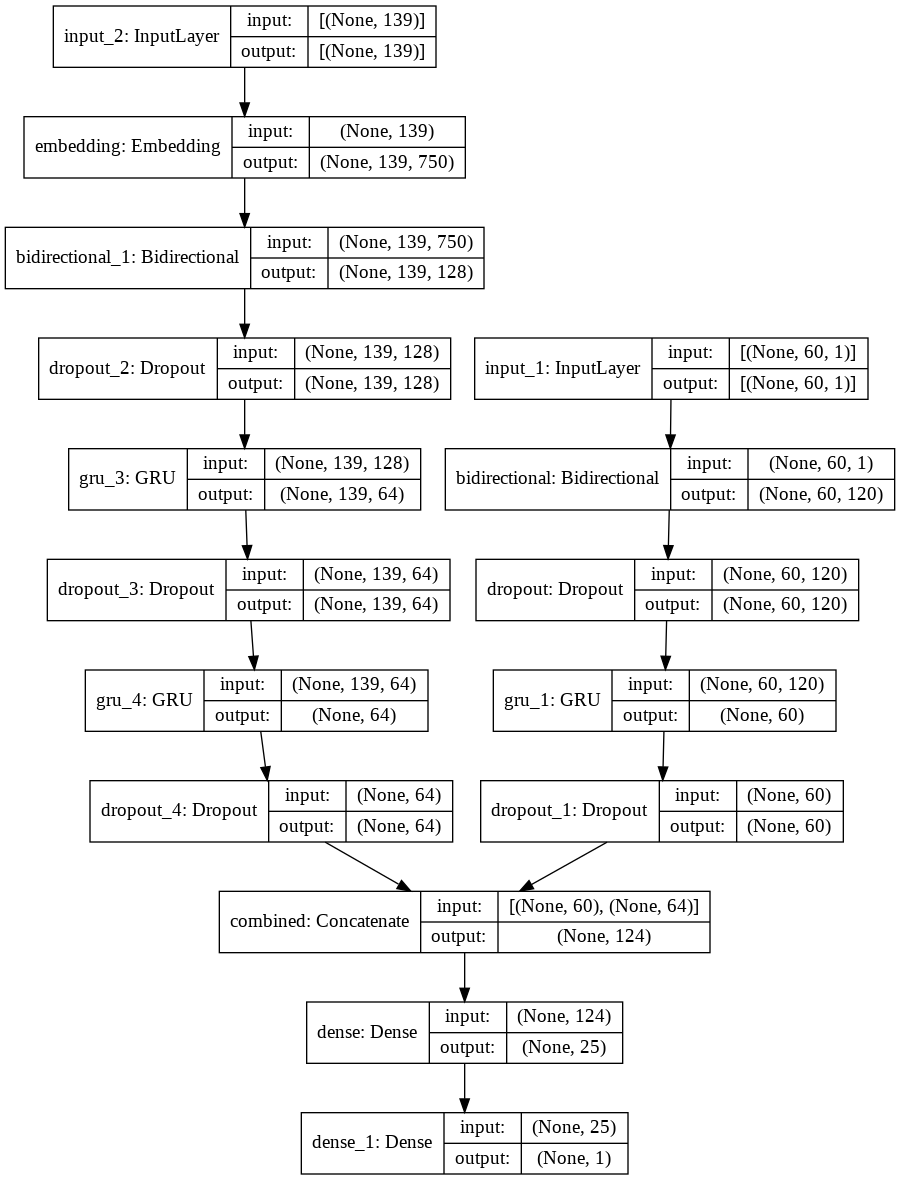

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(multi_model, show_shapes=True)

In [ ]:
from keras.callbacks import CSVLogger
logger_filename = '/content/drive/MyDrive/stock_prediction/AAPL/training_log_seq2seq_model.csv'

my_callback = [
               EarlyStopping(patience=5,monitor='val_loss'),
               CSVLogger(filename=logger_filename)

]

# training setting
epochs = 100
batch_size = 64

# Fitting to the training set
multi_model.fit([trainset['X'], news_train], trainset['y'], epochs=epochs, batch_size=batch_size, callbacks=my_callback
                              , validation_data=([valset['X'], news_val], valset['y']))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/100
30/30 [==============================] - 12s 203ms/step - loss: 0.0410 - val_loss: 0.0068
Epoch 2/100
30/30 [==============================] - 6s 206ms/step - loss: 0.0017 - val_loss: 9.1182e-04
Epoch 3/100
30/30 [==============================] - 6s 203ms/step - loss: 9.9653e-04 - val_loss: 8.8187e-04
Epoch 4/100
30/30 [==============================] - 6s 204ms/step - loss: 4.8125e-04 - val_loss: 3.9864e-04
Epoch 5/100
30/30 [==============================] - 6s 200ms/step - loss: 5.0403e-04 - val_loss: 3.6339e-04
Epoch 6/100
30/30 [==============================] - 6s 205ms/step - loss: 2.8660e-04 - val_loss: 4.1021e-04
Epoch 7/100
30/30 [==============================] - 6s 206ms/step - loss: 3.0865e-04 - val_loss: 6.7826e-04
Epoch 8/100
30/30 [==============================] - 6s 202ms/step - loss: 3.9673e-04 - val_loss: 7.5472e-04
Epoch 9/100
30/30 [==============================] - 6s 200ms/step - loss: 2.2508e-04 - val_loss: 3.5711e-04
Epoch 10/100
30/30 [==========

In [ ]:
multi_model.save('/content/drive/MyDrive/stock_prediction/AAPL/stock_pred_seq2seq_model.h5')

## Evaluation

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply t

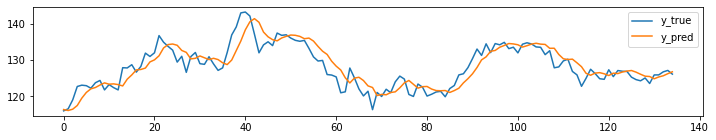

In [ ]:
def calculate_mse_multi(scaler, y_input, x_input, w2v):
    y_pred = multi_model.predict([x_input, w2v])
    MSE = mean_squared_error(y_input, y_pred)

    y_true = scaler.inverse_transform(y_input.reshape(-1,1))
    y_pred = scaler.inverse_transform(y_pred)

    real_mse = np.mean(np.square(y_true - y_pred))
    scaled_mse = real_mse/(np.max(y_true) - np.min(y_true)) * 100

    return MSE, scaled_mse, y_true, y_pred

train_MSE, train_scaled_mse, train_y, train_y_pred = calculate_mse_multi(scaler, trainset["y"], trainset["X"], news_train)
val_MSE, val_scaled_mse, val_y, val_y_pred = calculate_mse_multi(scaler, valset["y"], valset["X"], news_val)
test_MSE, test_scaled_mse, test_y, test_y_pred = calculate_mse_multi(scaler, testset["y"], testset["X"], news_test)

y_true = np.vstack((test_y))
y_pred = np.vstack((test_y_pred))


mse = {}
mse["train"] = train_MSE
mse["val"] = val_MSE
mse["test"] = test_MSE

scaled_mse = {}
scaled_mse["train"] = train_scaled_mse
scaled_mse["val"] = val_scaled_mse
scaled_mse["test"] = test_scaled_mse

pred_result = {}
pred_result["True"] = test_y
pred_result["Pred"] = test_y_pred

plt.figure(figsize=(12,2))
plt.plot(y_true)
plt.plot(y_pred)
plt.legend(['y_true','y_pred'])

In [ ]:
mse

{'test': 0.00048087083971378044,
 'train': 3.0263279913280293e-05,
 'val': 0.0004272634286974347}

In [ ]:
scaled_mse

{'test': 29.591781883568185,
 'train': 0.8497347908618537,
 'val': 10.366592497281042}

## Prediction

**Definition:**

◦ **Rise (0):** CP of Today > CP of Yesterday , Change Rate > 1.5 %

◦ **Remain Stable (1):** Change Rate ≤ 1.5 %

◦ **Fall (2):** CP of Today < CP of Yesterday , Change Rate > 1.5 %

In [ ]:
pred_df = pd.DataFrame(pred_result['Pred'], columns=['Pred'])
pred_df['True'] = pred_result['True']
pred_df = pred_df.tail(5)
pred_df['His_True'] = pred_result['True'][-6:][:5]
pred_df['His_Pred'] = pred_result['Pred'][-6:][:5]
pred_df['Pred_change_rate'] = (pred_df['Pred'] - pred_df['His_Pred']).abs()/pred_df['His_Pred']*100
pred_df['True_change_rate'] = (pred_df['True'] - pred_df['His_True']).abs()/pred_df['His_True']*100
pred_df

,Pred,True,His_True,His_Pred,Pred_change_rate,True_change_rate
130,124.832245,125.89,123.54,125.458717,0.499346,1.902218
131,125.336998,125.90,125.89,124.832245,0.404345,0.007943
132,125.662926,126.74,125.90,125.336998,0.260041,0.667196
133,126.238167,127.13,126.74,125.662926,0.457765,0.307717
134,126.753014,126.11,127.13,126.238167,0.407838,0.802328


In [ ]:
def change_type_pred(row):
    if row['Pred'] > row['His_Pred'] and row['Pred_change_rate'] > 1.5:
        return 0
    elif row['Pred'] < row['His_Pred'] and row['Pred_change_rate'] > 1.5:
        return 2
    else:
        return 1

def change_type_true(row):
    if row['True'] > row['His_True'] and row['True_change_rate'] > 1.5:
        return 0
    elif row['True'] < row['His_True'] and row['True_change_rate'] > 1.5:
        return 2
    else:
        return 1

pred_df['Pred_change_type'] = pred_df.apply(lambda row : change_type_pred(row), axis=1)
pred_df['True_change_type'] = pred_df.apply(lambda row : change_type_true(row), axis=1)

In [ ]:
pred_df

,Pred,True,His_True,His_Pred,Pred_change_rate,True_change_rate,Pred_change_type,True_change_type
130,124.832245,125.89,123.54,125.458717,0.499346,1.902218,1,0
131,125.336998,125.90,125.89,124.832245,0.404345,0.007943,1,1
132,125.662926,126.74,125.90,125.336998,0.260041,0.667196,1,1
133,126.238167,127.13,126.74,125.662926,0.457765,0.307717,1,1
134,126.753014,126.11,127.13,126.238167,0.407838,0.802328,1,1


# 7. Baseline Model

In [ ]:
%%time
# The LSTM architecture
regressorBiLSTM = Sequential()
# 1st layer with Dropout regularisation
regressorBiLSTM.add(Bidirectional(GRU(units=60, return_sequences=True), input_shape=(X_train.shape[1],1)))
regressorBiLSTM.add(Dropout(0.2))

# 2nd LSTM layer
regressorBiLSTM.add(GRU(units=60))
regressorBiLSTM.add(Dropout(0.2))

# Output layer
regressorBiLSTM.add(Dense(25))
regressorBiLSTM.add(Dense(units=1))

# Compiling LSTM 
regressorBiLSTM.compile(optimizer='adam', loss='mean_squared_error')
regressorBiLSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 60, 120)           22680     
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 120)           0         
_________________________________________________________________
gru_6 (GRU)                  (None, 60)                32760     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1525      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 26        
Total params: 56,991
Trainable params: 56,991
Non-trainable params: 0
____________________________________________________

In [ ]:
logger_filename = '/content/drive/MyDrive/stock_prediction/AAPL/training_log_bilstm_model.csv'

my_callback = [
               EarlyStopping(patience=5,monitor='val_loss'),
               CSVLogger(filename=logger_filename)

]

# training setting
epochs = 100
batch_size = 64

# Fitting to the training set
regressorBiLSTM.fit(trainset['X'], trainset['y'], epochs=epochs, batch_size=batch_size, callbacks=my_callback
                              , validation_data=(valset['X'], valset['y']))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/100
30/30 [==============================] - 2s 62ms/step - loss: 0.0102 - val_loss: 3.8059e-04
Epoch 2/100
30/30 [==============================] - 2s 60ms/step - loss: 4.1907e-04 - val_loss: 5.6211e-04
Epoch 3/100
30/30 [==============================] - 2s 59ms/step - loss: 2.6537e-04 - val_loss: 3.7883e-04
Epoch 4/100
30/30 [==============================] - 2s 59ms/step - loss: 4.2612e-04 - val_loss: 0.0011
Epoch 5/100
30/30 [==============================] - 2s 59ms/step - loss: 2.8977e-04 - val_loss: 0.0017
Epoch 6/100
30/30 [==============================] - 2s 58ms/step - loss: 2.5580e-04 - val_loss: 6.8497e-04
Epoch 7/100
30/30 [==============================] - 2s 59ms/step - loss: 2.0509e-04 - val_loss: 7.7930e-04
Epoch 8/100
30/30 [==============================] - 2s 59ms/step - loss: 1.8772e-04 - val_loss: 3.4616e-04
Epoch 9/100
30/30 [==============================] - 2s 59ms/step - loss: 1.8416e-04 - val_loss: 5.1265e-04
Epoch 10/100
30/30 [====================

In [ ]:
regressorBiLSTM.save('/content/drive/MyDrive/stock_prediction/AAPL/stock_pred_bilstm_model.h5')

## Evaluation

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply t

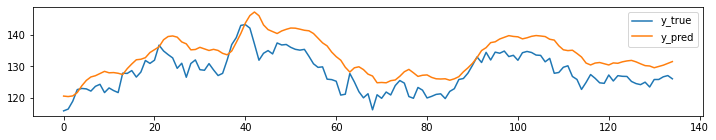

In [ ]:
def calculate_mse(scaler, y_input, x_input):
    y_pred = regressorBiLSTM.predict(x_input)
    MSE = mean_squared_error(y_input, y_pred)

    y_true = scaler.inverse_transform(y_input.reshape(-1,1))
    y_pred = scaler.inverse_transform(y_pred)

    real_mse = np.mean(np.square(y_true - y_pred))
    scaled_mse = real_mse/(np.max(y_true) - np.min(y_true)) * 100

    return MSE, scaled_mse, y_true, y_pred

train_MSE, train_scaled_mse, train_y, train_y_pred = calculate_mse(scaler, trainset["y"], trainset["X"])
val_MSE, val_scaled_mse, val_y, val_y_pred = calculate_mse(scaler, valset["y"], valset["X"])
test_MSE, test_scaled_mse, test_y, test_y_pred = calculate_mse(scaler, testset["y"], testset["X"])

y_true = np.vstack((test_y))
y_pred = np.vstack((test_y_pred))


mse = {}
mse["train"] = train_MSE
mse["val"] = val_MSE
mse["test"] = test_MSE

scaled_mse = {}
scaled_mse["train"] = train_scaled_mse
scaled_mse["val"] = val_scaled_mse
scaled_mse["test"] = test_scaled_mse

plt.figure(figsize=(12,2))
plt.plot(y_true)
plt.plot(y_pred)
plt.legend(['y_true','y_pred'])

In [ ]:
mse

{'test': 0.0020543185266598146,
 'train': 6.526608290309821e-05,
 'val': 0.0005038990227674774}

In [ ]:
scaled_mse

{'test': 126.41840295179834,
 'train': 1.8325453438004402,
 'val': 12.22600580218653}

# 8. Full-connected Network with TF-IDF
## Headlines Input Preparation

In [ ]:
train_data.head()

,index,Close,Title,text_decont,text_no_punc,tk,tfidf,tfidf_new
Date,,,,,,,,
2012-05-18,0,18.94,,,,,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2012-05-21,1,20.05,"Boot up: web v apps, Google v France, the iPho...","boot up: web v apps, google v france, the ipho...",boot up web v apps google v france the ipho...,"[boot, up, web, v, apps, google, v, france, th...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2012-05-22,2,19.89,,,,,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2012-05-23,3,20.38,,,,,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2012-05-24,4,20.19,"Boot up: Facebook's coming crash, iPhone gende...","boot up: facebook is coming crash, iphone gend...",boot up facebook is coming crash iphone gend...,"[boot, up, facebook, is, coming, crash, iphone...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
train_news = np.matrix(train_data.tfidf_new[n_lags:].tolist())
#train_news = train_news.reshape(train_news.shape[0],1)

val_news = np.matrix(val_data.tfidf_new[n_lags:].tolist())
#val_news = val_news.reshape(val_news.shape[0],1)

test_news = np.matrix(test_data.tfidf_new[n_lags:].tolist())
#test_news = test_news.reshape(test_news.shape[0],1)

In [ ]:
print('News to train:',train_news.shape)
print('\nNews to test:',test_news.shape)
print('\nNews to val:',val_news.shape)

News to train: (1857, 3892)

News to test: (135, 3892)

News to val: (108, 3892)


## Model

In [ ]:
%%time
# LSTM architecture
# FIRST BRANCH operates on the first input
# 1st layer with Dropout regularisation
lstm_input = Input(shape=(X_train.shape[1],1))
x = Bidirectional(GRU(units=60, return_sequences=True))(lstm_input)
x = Dropout(0.2)(x)

# 2nd LSTM layer
x = GRU(units=60)(x)
x = Dropout(0.2)(x)

lstm_branch = Model(inputs=lstm_input, outputs=x)

# SECOND BRANCH operates on the first input
dense_input = Input(shape=(len(tfvec.get_feature_names()),))
y = Dense(50)(dense_input)
y = Dropout(0.2)(y)
technical_indicators_branch = Model(inputs=dense_input, outputs=y)

# combine the output of the two branches
combined = concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')
# Output layer
z = Dense(25)(combined)
z = Dense(units=1)(z)
multi_model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)

# Compiling
multi_model.compile(optimizer='adam', loss='mean_squared_error')

CPU times: user 746 ms, sys: 17 ms, total: 763 ms
Wall time: 766 ms


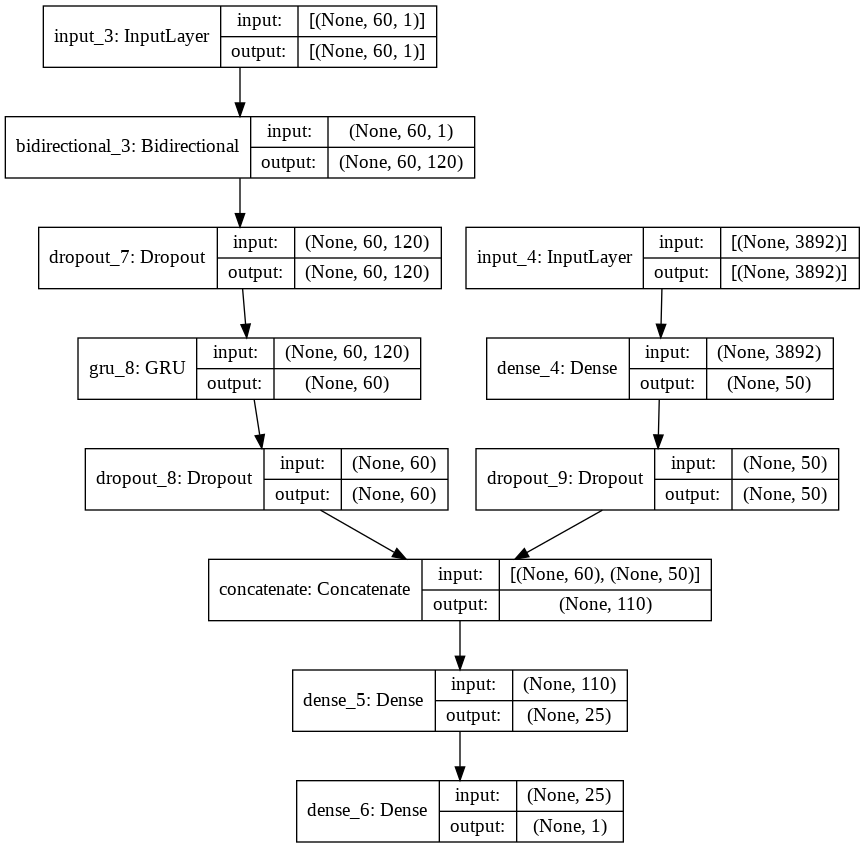

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(multi_model, show_shapes=True)

In [ ]:
from keras.callbacks import CSVLogger
logger_filename = '/content/drive/MyDrive/stock_prediction/AAPL/training_log_fc_model.csv'

my_callback = [
               EarlyStopping(patience=5,monitor='val_loss'),
               CSVLogger(filename=logger_filename)

]

# training setting
epochs = 100
batch_size = 64

# Fitting to the training set
multi_model.fit([trainset['X'], train_news], trainset['y'], epochs=epochs, batch_size=batch_size, callbacks=my_callback
                              , validation_data=([valset['X'], val_news], valset['y']))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/100
30/30 [==============================] - 2s 63ms/step - loss: 0.0104 - val_loss: 0.0037
Epoch 2/100
30/30 [==============================] - 2s 62ms/step - loss: 6.9192e-04 - val_loss: 0.0016
Epoch 3/100
30/30 [==============================] - 2s 66ms/step - loss: 3.2550e-04 - val_loss: 0.0017
Epoch 4/100
30/30 [==============================] - 2s 63ms/step - loss: 4.6346e-04 - val_loss: 8.4573e-04
Epoch 5/100
30/30 [==============================] - 2s 65ms/step - loss: 2.8938e-04 - val_loss: 9.7896e-04
Epoch 6/100
30/30 [==============================] - 2s 65ms/step - loss: 1.9061e-04 - val_loss: 6.9673e-04
Epoch 7/100
30/30 [==============================] - 2s 63ms/step - loss: 1.9126e-04 - val_loss: 0.0014
Epoch 8/100
30/30 [==============================] - 2s 62ms/step - loss: 2.0897e-04 - val_loss: 5.2773e-04
Epoch 9/100
30/30 [==============================] - 2s 62ms/step - loss: 1.5833e-04 - val_loss: 3.6720e-04
Epoch 10/100
30/30 [============================

In [ ]:
multi_model.save('/content/drive/MyDrive/stock_prediction/AAPL/stock_pred_fc_model.h5')

## Evaluation

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply t

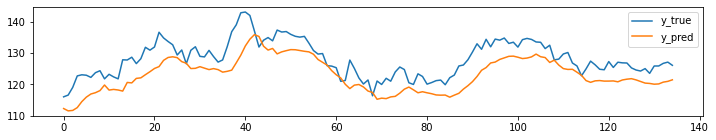

In [ ]:
def calculate_mse_multi(scaler, y_input, x_input, tfidf):
    y_pred = multi_model.predict([x_input, tfidf])
    MSE = mean_squared_error(y_input, y_pred)

    y_true = scaler.inverse_transform(y_input.reshape(-1,1))
    y_pred = scaler.inverse_transform(y_pred)

    real_mse = np.mean(np.square(y_true - y_pred))
    scaled_mse = real_mse/(np.max(y_true) - np.min(y_true)) * 100

    return MSE, scaled_mse, y_true, y_pred

train_MSE, train_scaled_mse, train_y, train_y_pred = calculate_mse_multi(scaler, trainset["y"], trainset["X"], train_news)
val_MSE, val_scaled_mse, val_y, val_y_pred = calculate_mse_multi(scaler, valset["y"], valset["X"], val_news)
test_MSE, test_scaled_mse, test_y, test_y_pred = calculate_mse_multi(scaler, testset["y"], testset["X"], test_news)

y_true = np.vstack((test_y))
y_pred = np.vstack((test_y_pred))


mse = {}
mse["train"] = train_MSE
mse["val"] = val_MSE
mse["test"] = test_MSE

scaled_mse = {}
scaled_mse["train"] = train_scaled_mse
scaled_mse["val"] = val_scaled_mse
scaled_mse["test"] = test_scaled_mse

plt.figure(figsize=(12,2))
plt.plot(y_true)
plt.plot(y_pred)
plt.legend(['y_true','y_pred'])

In [ ]:
mse

{'test': 0.001983904865335473,
 'train': 9.721211159682419e-05,
 'val': 0.001793054172801172}

In [ ]:
scaled_mse

{'test': 122.08519176360586,
 'train': 2.7295300851112296,
 'val': 43.50446593008275}